# CNN Model 2b
## Preprocessing method: image_dataset_from_directory()
## Image size: (224, 224) 
## Images: RGB
## No pretrained layers
## No image transformation

In [1]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
path_training = 'gender_images/Training/'
path_validation = 'gender_images/Validation/'

In [3]:
image_size = (224, 224)
batch_size = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(path_training,
                                                               color_mode = "rgb",
                                                               seed=1993,
                                                               image_size = image_size)

val_ds =  tf.keras.preprocessing.image_dataset_from_directory(path_validation,
                                                              seed=1993,
                                                              color_mode = "rgb",
                                                              image_size = image_size)

one_hot_encoded_train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))
one_hot_encoded_val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))

Found 47009 files belonging to 2 classes.
Found 11649 files belonging to 2 classes.


In [4]:
inputs = keras.Input(shape=image_size)
x = layers.Rescaling(1./255)(inputs)

In [5]:
plt.figure(figsize=(10, 10))
class_names = val_ds.class_names
for images, labels in val_ds.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 2
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [7]:
# Set early stopping after certain number of epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
epochs = 1000     # Set epochs

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                              

                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 28, 28, 512)  267264     ['activation_7[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 28, 28, 512)  2048       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 512)  0          ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 512)  131584      ['add_1[0][0]']                  
          

In [9]:
face_fit = model.fit(
  one_hot_encoded_train_ds,
  validation_data= one_hot_encoded_val_ds,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/1000
1470/1470 [==============================] - 137s 88ms/step - loss: 0.2059 - accuracy: 0.9186 - val_loss: 0.2005 - val_accuracy: 0.9213
Epoch 2/1000
1470/1470 [==============================] - 127s 86ms/step - loss: 0.1344 - accuracy: 0.9506 - val_loss: 0.1534 - val_accuracy: 0.9500
Epoch 3/1000
1470/1470 [==============================] - 127s 87ms/step - loss: 0.1197 - accuracy: 0.9577 - val_loss: 0.1936 - val_accuracy: 0.9300
Epoch 4/1000
1470/1470 [==============================] - 127s 87ms/step - loss: 0.1066 - accuracy: 0.9614 - val_loss: 0.0994 - val_accuracy: 0.9660
Epoch 5/1000
1470/1470 [==============================] - 127s 87ms/step - loss: 0.0972 - accuracy: 0.9644 - val_loss: 0.1291 - val_accuracy: 0.9528
Epoch 6/1000
1470/1470 [==============================] - 127s 87ms/step - loss: 0.0881 - accuracy: 0.9673 - val_loss: 0.0904 - val_accuracy: 0.9672
Epoch 7/1000
1470/1470 [==============================] - 127s 87ms/step - loss: 0.0768 - accuracy: 0.9728

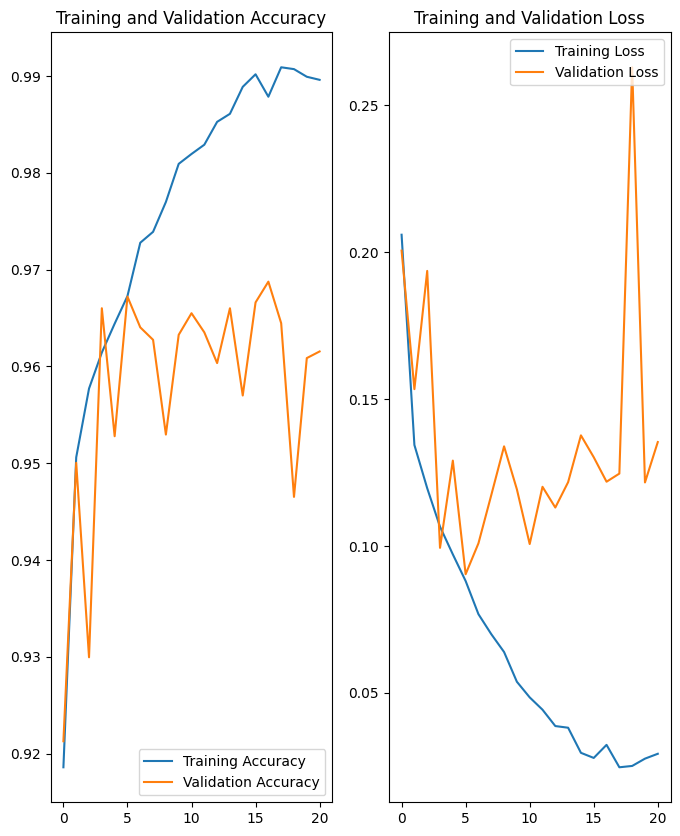

In [12]:
acc= face_fit.history['accuracy']
val_acc = face_fit.history['val_accuracy']

loss = face_fit.history['loss']
val_loss = face_fit.history['val_loss']

import matplotlib.pyplot as plt

epochs_range = range(0,21)

plt.figure(figsize=(8, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [13]:
model.save('GC weights/Unfrozen/mod2b-RGB')
model.save_weights('GC weights/Unfrozen/mod2b-RGB/mod2b_RGB.h5')

INFO:tensorflow:Assets written to: GC weights/Unfrozen/mod2b-RGB/assets


INFO:tensorflow:Assets written to: GC weights/Unfrozen/mod2b-RGB/assets
